### Plot temperature and humidity data

In [47]:
from datetime import datetime
from datetime import timedelta
import numpy as np

def read_data(file_path, smooth_N):
    trace = []
    with open(file_path, 'r') as f:
        # extract start time from start time
        first_line = f.readline()
        data = first_line.strip().split(',')
        start_time = datetime.strptime(data[0], '%H:%M:%S.%f')
        last_time = start_time
        negFlag = False # use a flag to avoid loops
        breakFlag = False

        while True:
            buf = []
            for i in range(0, smooth_N):
                line = f.readline()
                if line == '':
                    breakFlag = True
                    break
                data = line.strip().split(',')
                cur_time = datetime.strptime(data[0], '%H:%M:%S.%f')
                # elapsed time in hours
                elapsed_time_h = (cur_time - start_time).total_seconds() / 3600
                
                if elapsed_time_h < 0:
                    # add another day to avoid negative elapsed time
                    negFlag = True
                    elapsed_time_h += 24
                elif negFlag == True and elapsed_time_h > 0:
                    # finish processing all the data, end the loop
                    breakFlag = True
                    break

                # process voltage, current and power data
                temp = int(data[5])
                humid = int(data[6])
                buf.append([elapsed_time_h, temp, humid])
                
            # use the average
            if len(buf) != 0: # buf is not empty
                buf = np.array(buf)
                trace.append(np.mean(buf, axis=0))
            
            if breakFlag:
                break
    return np.array(trace)

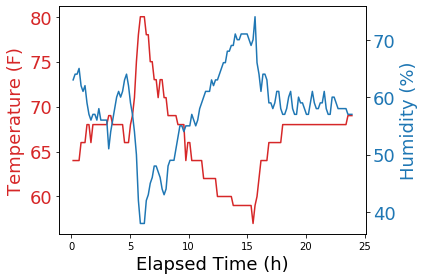

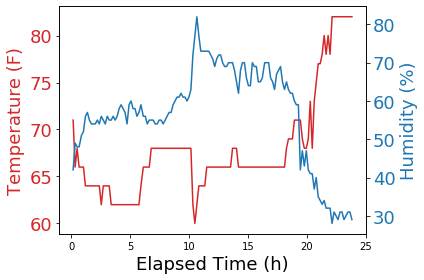

In [48]:
import matplotlib.pyplot as plt
def plot(trace, fname):
    fig, ax1 = plt.subplots()
    color = "tab:red"
    ax1.plot(trace[:, 0], trace[:, 1], color=color)
    ax1.set_xlabel("Elapsed Time (h)", fontsize=18)
    ax1.set_ylabel("Temperature (F)", color=color, fontsize=18)
    ax1.tick_params(axis='y', labelcolor=color, labelsize=18)

    ax2 = ax1.twinx()
    color = "tab:blue"
    ax2.plot(trace[:, 0], trace[:, 2], color=color)
    ax2.set_ylabel('Humidity (%)', color=color, fontsize=18)
    ax2.tick_params(axis='y', labelcolor=color, labelsize=18)

    fig.tight_layout()
    plt.savefig(fname, dpi=300)

data_solar = read_data('./data/recv_data_solar.txt', 1)
data_bat = read_data('./data/recv_data_bat.txt', 1)

plot(data_solar, './img/solar.png')
plot(data_bat, './img/bat.png')

### Test before implementation: calculate the gradient factor x in a EWMA manner

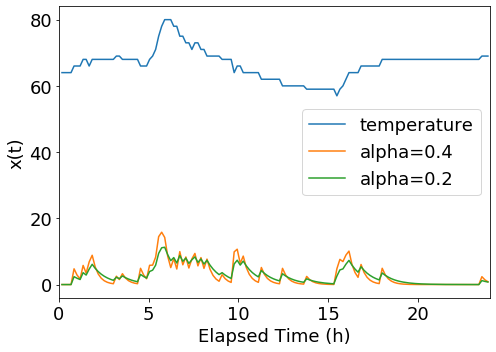

In [49]:
def gen_x(alpha):
    last_x = 0
    x = [last_x]
    for i in range(1, data_solar.shape[0]):
        # calculate the gradient in the past interval
        grad = abs(data_solar[i, 1] - data_solar[i-1, 1]) / (data_solar[i, 0] - data_solar[i-1, 0])
        new_x = alpha * grad + (1 - alpha) * last_x
        x.append(new_x)
        last_x = new_x
    return x


I = []
x = gen_x(0.4)
I_max = 40
I_min = 5
k = (I_max - I_min) / max(x)
for ele in x:
    next_I = I_max - k * ele
    I.append(next_I)

plt.figure(figsize=(7, 5))
plt.plot(data_solar[:, 0], data_solar[:, 1], label='temperature')
plt.plot(data_solar[:, 0], x, label='alpha=0.4')
plt.plot(data_solar[:, 0], gen_x(0.2), label='alpha=0.2')
plt.xlim((0, 24))
plt.xlabel("Elapsed Time (h)", fontsize=18)
plt.ylabel("x(t)", fontsize=18)
plt.tick_params(labelsize=18)
plt.legend(fontsize=18)
plt.tight_layout()

### Process the adaptive sampling result

In [50]:
def read_data_adp(file_path, smooth_N):
    trace = []
    with open(file_path, 'r') as f:
        # extract start time from start time
        first_line = f.readline()
        data = first_line.strip().split(',')
        start_time = datetime.strptime(data[0], '%H:%M:%S.%f')
        last_time = start_time
        negFlag = False # use a flag to avoid loops
        breakFlag = False

        while True:
            buf = []
            for i in range(0, smooth_N):
                line = f.readline()
                if line == '':
                    breakFlag = True
                    break
                data = line.strip().split(',')
                cur_time = datetime.strptime(data[0], '%H:%M:%S.%f')
                # elapsed time in hours
                elapsed_time_h = (cur_time - start_time).total_seconds() / 3600
                
                if elapsed_time_h < 0:
                    # add another day to avoid negative elapsed time
                    negFlag = True
                    elapsed_time_h += 24
                elif negFlag == True and elapsed_time_h > 0:
                    # finish processing all the data, end the loop
                    breakFlag = True
                    break

                # process voltage, current and power data
                temp = int(data[5])
                humid = int(data[6])
                next_interval = int(data[12]) / 60
                buf.append([elapsed_time_h, temp, humid, next_interval])
                
            # use the average
            if len(buf) != 0: # buf is not empty
                buf = np.array(buf)
                trace.append(np.mean(buf, axis=0))
            
            if breakFlag:
                break
    return np.array(trace)

# use normal read_data function to obtain the refer data
data_refer = read_data('./data/refer_data.txt', 5)
# read adaptive sampling data
data_adp = read_data_adp('./data/adp_data.txt', 1)

### plot the adaptive sampling data

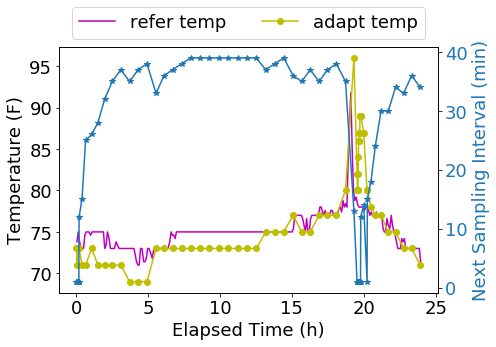

In [51]:
fig, ax1 = plt.subplots(figsize=(7, 5))
color = "tab:red"
ax1.plot(data_refer[:, 0], data_refer[:, 1], 'm', label='refer temp')
ax1.plot(data_adp[:, 0], data_adp[:, 1], 'y-o', label='adapt temp')
ax1.set_xlabel("Elapsed Time (h)", fontsize=18)
ax1.set_ylabel("Temperature (F)", fontsize=18)
ax1.tick_params(labelsize=18)
ax1.legend(loc='upper center', ncol=2, fontsize=18, bbox_to_anchor=(0.5, 1.2))

ax2 = ax1.twinx()
color = "tab:blue"
ax2.plot(data_adp[:, 0], data_adp[:, 3], '-*', color=color)
ax2.set_ylabel('Next Sampling Interval (min)', color=color, fontsize=18)
ax2.tick_params(axis='y', labelcolor=color, labelsize=18)

fig.tight_layout()
plt.savefig('./img/adp.png', dpi=300)